In [1]:
import pandas as pd 
data = pd.read_csv('CE802_Ass_2019_Data.csv').sample(frac=1)
test_features = pd.read_csv('CE802_Ass_2019_Test.csv').drop("Class", axis=1)

In [2]:
cor_mat = data.corr()
cor_mat["Class"].sort_values(ascending=False);

In [3]:
split = int(len(data) * 0.15)
validation = data[0:split]
train = data[split:]

In [4]:
train_labels = train["Class"]
train_features = train.drop("Class", axis=1)
validation_labels = validation["Class"]
validation_features = validation.drop("Class", axis=1)

In [5]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def featureSelection(X, level='low'):
    type(X)
    if level == 'low':
        return X
    if level == 'mid':
        return X.drop(['F18', 'F8', 'F11', 'F17'], axis=1)
    if level == 'high':
        return X.drop(['F16', 'F3', 'F5', 'F18', 'F8', 'F11', 'F17', 'F6', 'F2', 'F15'], axis=1)

def imputeF20(X, method='none'):
    if method == 'none':
        return pd.DataFrame(X)
    if method == 'drop':
        X = X.drop("F20",axis=1).values
        return pd.DataFrame(X)
    if method == 'constant':
        imp = SimpleImputer(strategy='constant')
    if method == 'mean':
        imp = SimpleImputer(strategy='mean')
    if method == 'knn':
        imp = KNNImputer(n_neighbors=5)

    imp.fit(X)
    return pd.DataFrame(imp.transform(X))

def scale(X, method='none'):
    if method == 'none':
        return pd.DataFrame(X)
    if method == 'norm':
        scaler = MinMaxScaler()
    if method == 'std':
        scaler = StandardScaler()
    
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X))

In [6]:
selection_level = 'mid'
imputation_method = 'mean'
scaling_method = 'norm'

train_features_procesed = featureSelection(train_features, level=selection_level)
train_features_procesed = imputeF20(train_features_procesed, imputation_method)
train_features_procesed = scale(train_features_procesed, scaling_method )

validation_features_procesed = featureSelection(validation_features, selection_level)
validation_features_procesed = imputeF20(validation_features_procesed, imputation_method)
validation_features_procesed = scale(validation_features_procesed, scaling_method )

In [7]:
#### Prunned Decision tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [8]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(train_features_procesed, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [9]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_features_procesed, train_labels)
    clfs.append(clf)

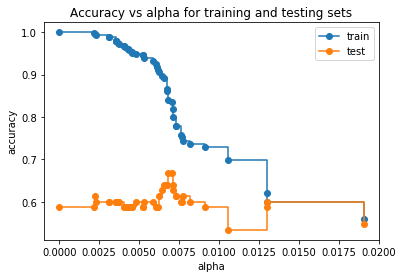

In [10]:
train_scores = [clf.score(train_features_procesed, train_labels) for clf in clfs]
test_scores = [clf.score(validation_features_procesed, validation_labels) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [11]:
def evaluateClassifier(clf):
    clf.fit(train_features_procesed, train_labels)
    results = clf.predict(validation_features_procesed)
    return f1_score(validation_labels, results)

In [12]:
from sklearn.metrics import f1_score

clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01)
decision_tree_f1 = evaluateClassifier(clf)
print(decision_tree_f1)

0.5507246376811593


In [13]:
### Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
logistic_regression_f1 = evaluateClassifier(clf)
print(logistic_regression_f1)

0.4931506849315069


In [14]:
### Support vector machines
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
params = [
    {'kernel':['linear', 'rbf', 'sigmoid']},
    {'kernel': ['rbf'], 'gamma':[0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
]
clf = SVC()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)

clf = SVC(kernel='rbf', gamma=1)
svm_f1 = evaluateClassifier(clf)
print(svm_f1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
0.5373134328358209


In [15]:
### KNN
from sklearn.neighbors import KNeighborsClassifier
params = [
    {'n_neighbors':[3,4,5,7,9], 'weights': ['uniform', 'distance'], 'algorithm':['auto'], 'p':[1, 2]}
    ]
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)



clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', n_neighbors=3, p=1, weights='uniform')
knn_f1 = evaluateClassifier(clf)
print(knn_f1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='distance')
0.3225806451612903


In [16]:
### Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
naive_bayes_f1 = evaluateClassifier(clf)
print(naive_bayes_f1)

0.6265060240963856


In [17]:
### Perceptron
from sklearn.linear_model import Perceptron

params = [
    {'penalty':[None,'l1','l2','elasticnet']}
    ]
clf = Perceptron()
grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
grid_search.fit(train_features_procesed, train_labels)
print(grid_search.best_estimator_)

clf = Perceptron(penalty='l2')
perceptron_f1 = evaluateClassifier(clf)
print(perceptron_f1)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
0.53125


In [18]:
### MLP
from sklearn.neural_network import MLPClassifier

params = [
        {'hidden_layer_sizes':[(10, ),(50, ),(100, ),(150, ),(200, )]},
        {'activation':['identity', 'logistic', 'tanh', 'relu']},
        {'solver': ['lbfgs', 'adam']},
        {'alpha':[0.0001, 0.01]},
        {'learning_rate': ['constant','invscaling','adaptive']},
        {'random_state': [0]},
        {'early_stopping': [True]},

    ]
# clf = MLPClassifier()
# grid_search = GridSearchCV(clf, params, cv=3, scoring="f1", return_train_score=True)
# grid_search.fit(train_features_procesed, train_labels);
# print(grid_search.best_estimator_)

In [20]:
clf = MLPClassifier(max_iter=500, activation='relu', alpha=0.0001, batch_size='auto', early_stopping=False,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, random_state=0,  solver='lbfgs')
mlp_f1 = evaluateClassifier(clf)
print(mlp_f1)

0.6129032258064516
